In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

pd.options.mode.chained_assignment = None

sns.set_theme(style="whitegrid", palette="viridis")
sns.set_palette("viridis")

# 2. fáza - Predspracovanie údajov

#### Percentuálny podiel práce: Stahovec = 50%, Viest = 50%

## a) Integrácia a čistenie dát
-------------------------------------------------------

Úvod do 2. fázy predstavuje realizáciu návrhov z konca 1. fázy.
Keďže sme na začiatok exploratívnej analýzy dát nahradzovali chýbajúce hodnoty
priemerom, túto skutočnosť obídeme tak, že si dáta zo súboru načítame znovu a
na tom vyskúšame a zrealizujeme rôzne metódy na úpravu chýbajúcich hodnôt.

Ešte predtým sme vykonali rôzne čistiacie operácie a prípravu dát.

Začali sme načítaním datasetu labor nanovo.

In [391]:
data_labor = pd.read_csv("dataset/labor.csv", sep="\t")
data_labor = data_labor.iloc[:, 1:]
data_labor.head(15)

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name,trombocyty,alp,relationship,indicator,er-cv,weight,ast,hematokrit
0,yes,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,45.93625,divoced,0.0,55.43592,-2.73558,51.62366,3.34206
1,yes,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,20.30249,divoced,0.0,45.34617,81.56533,61.59374,5.78180
2,no,6.51444,7.94461,1.28337,5.83567,6.88758,6.45793,881-46-4810,Crystal Kelley,6.02783,82.09305,divoced,0.0,29.29190,151.24191,47.96329,4.55230
3,no,6.05025,7.67537,0.83197,6.33300,4.45912,6.96013,826-16-7757,Doris Duncan,6.83876,69.43441,divoced,1.0,60.47398,83.89451,57.47174,7.17271
4,yes,6.20737,7.84993,0.93395,5.66904,4.88628,6.41332,167-37-6059,John Parks,5.75903,90.09567,divoced,1.0,41.10299,107.22958,34.25820,6.93681
5,no,6.43927,5.78198,0.38563,5.68222,3.97928,4.90713,289-95-2344,Shawn Richardson,6.70422,55.98531,divoced,0.0,70.18438,45.97264,43.98447,4.77041
6,yes,6.20765,5.61952,0.54770,3.98821,6.22502,7.63128,684-70-5275,Janice Buchanan,7.42329,54.79463,single,1.0,52.69461,34.70731,70.42152,7.60427
7,no,4.31997,8.26529,1.53396,5.57558,4.13495,7.57753,555-32-3180,Catherine Jackson,5.60203,65.09512,married,1.0,49.80798,91.49829,67.64974,7.25248
8,no,4.82413,6.25616,0.54975,6.43054,5.79923,6.90669,479-42-8879,Amanda Garcia,6.36469,72.65451,widowed,1.0,54.45955,118.55927,44.94089,6.92202
9,no,5.74884,6.66503,0.52396,6.99089,5.59373,8.31328,375-27-0860,Travis Brown,5.38674,26.96196,married,1.0,42.93586,81.83422,38.56586,6.65939


Rovnako aj profiles.csv je načítaný nanovo.

In [392]:
data_profiles = pd.read_csv("dataset/profiles.csv", sep="\t")
data_profiles = data_profiles.iloc[:, 1:]
data_profiles.head(15)

,birthdate,address,race,current_location,blood_group,ssn,name,sex,residence
0,1956/01/07,"76379 Lynn Drive\r\nKevinchester, VA 69374",Asian,"(Decimal('44.490493'), Decimal('-141.873900'))",A-,328-14-6945,Michelle Perez,F,39446 Gabrielle Pass Suite 764\r\nEast Daniell...
1,"10/28/1984, 00:00:00","PSC 8195, Box 7465\r\nAPO AP 27883",White,"(Decimal('-60.5512795'), Decimal('101.998999'))",B+,841-17-8814,Christopher Bishop,M,"18019 Mary Mountains\r\nScottport, IA 19641"
2,1966-08-30,"3345 Daniels Parks Suite 080\r\nNew Nancy, TX ...",Asian,"(Decimal('-24.9800585'), Decimal('-18.208792'))",A-,871-67-9396,Emily Stevens,F,"4906 Matthew Field\r\nGalvanfort, SC 22896"
3,1910/08/08,"3368 Brent Mall Suite 782\r\nPort Cheryl, WV 0...",black,"(Decimal('51.679296'), Decimal('-96.270056'))",O+,859-80-8937,Carla Hernandez,F,USCGC Schroeder\r\nFPO AE 57164
4,1972-10-28,"175 Michael Neck\r\nSouth Nicoleberg, PA 96022",White,"(Decimal('-85.5392635'), Decimal('-154.434283'))",O+,481-92-7602,Anthony Smith,M,"2148 Webb Valley\r\nNorth Madison, KS 07434"
5,31 Mar 1989,USNV Johnson\r\nFPO AP 32339,white,"(Decimal('-14.0121985'), Decimal('-122.796017'))",AB-,273-99-1555,Scott Campbell,M,"4115 Bowman Coves Apt. 957\r\nHollandland, NJ ..."
6,06 Dec 1917,Unit 3895 Box 8817\r\nDPO AA 44069,Asian,"(Decimal('-35.169301'), Decimal('-153.383042'))",A-,564-52-3982,Ryan Ramirez,M,14408 Robert Mountains Suite 672\r\nRichardpor...
7,2005-03-30,"65932 Benjamin Trafficway\r\nBradleyview, MN 6...",White,"(Decimal('-76.0427015'), Decimal('-176.397613'))",B+,443-16-4619,John Martinez,M,Unit 1668 Box 0922\r\nDPO AE 29854
8,10 Aug 1920,"31360 Caleb Isle Suite 718\r\nLynnfurt, OH 70966",Black,"(Decimal('-86.563849'), Decimal('-164.137234'))",A+,667-24-8122,Ricardo Wright,M,"28996 Jacobs Rue\r\nPort Rachaelside, NE 55686"
9,2012-06-28,"8584 Branch Isle\r\nBrianshire, ND 32402",White,"(Decimal('-21.404155'), Decimal('105.809768'))",O+,421-41-3600,Angela Mcgee,F,"49107 Ortiz Hills Suite 611\r\nHouseborough, T..."


A následne sme spojili oba datasety do jedného skrz parameter ssn.
Všetky čistiace a transformačné operácie budú vykonávané už len na tomto
datasete, ktorý sa volá merged_data.

In [393]:
merged_data = pd.merge(data_labor, data_profiles, on="ssn")
merged_data.head(15)

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,yes,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,"05/10/1923, 00:00:00","PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"(Decimal('56.944534'), Decimal('42.355764'))",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
1,no,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,"05/10/1923, 00:00:00","PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"(Decimal('56.944534'), Decimal('42.355764'))",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
2,yes,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,"05/10/1923, 00:00:00","PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"(Decimal('56.944534'), Decimal('42.355764'))",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
3,yes,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,"12/08/1923, 00:00:00","175 Anita Pass\r\nLake Davidchester, NC 93833",Asian,"(Decimal('84.160623'), Decimal('21.685531'))",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
4,Y,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,"12/08/1923, 00:00:00","175 Anita Pass\r\nLake Davidchester, NC 93833",Asian,"(Decimal('84.160623'), Decimal('21.685531'))",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
5,Y,6.05162,6.77173,0.45377,4.84219,NaN,6.35723,513-39-9691,Jocelyn Kelly,5.20885,...,38.20747,5.74776,"12/08/1923, 00:00:00","175 Anita Pass\r\nLake Davidchester, NC 93833",Asian,"(Decimal('84.160623'), Decimal('21.685531'))",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
6,no,6.51444,7.94461,1.28337,5.83567,6.88758,6.45793,881-46-4810,Crystal Kelley,6.02783,...,47.96329,4.55230,"04/25/1939, 00:00:00","9086 Danny Cliff\r\nMitchellport, NM 64440",black,"(Decimal('75.7681605'), Decimal('-60.890199'))",A-,Crystal Kelley,F,Unit 6525 Box 9751\r\nDPO AP 62291
7,no,6.34520,7.38959,0.86698,4.17522,4.90444,3.91870,881-46-4810,Crystal Kelley,4.13432,...,46.57264,5.67578,"04/25/1939, 00:00:00","9086 Danny Cliff\r\nMitchellport, NM 64440",black,"(Decimal('75.7681605'), Decimal('-60.890199'))",A-,Crystal Kelley,F,Unit 6525 Box 9751\r\nDPO AP 62291
8,no,5.31645,7.41004,0.85142,7.38934,5.33935,4.28161,881-46-4810,Crystal Kelley,6.85927,...,44.68660,7.87799,"04/25/1939, 00:00:00","9086 Danny Cliff\r\nMitchellport, NM 64440",black,"(Decimal('75.7681605'), Decimal('-60.890199'))",A-,Crystal Kelley,F,Unit 6525 Box 9751\r\nDPO AP 62291
9,no,6.05025,7.67537,0.83197,6.33300,4.45912,6.96013,826-16-7757,Doris Duncan,6.83876,...,57.47174,7.17271,1947/06/17,USNV Lewis\r\nFPO AA 51211,Indian,"(Decimal('51.933690'), Decimal('-76.430283'))",O+,Doris Duncan,F,"7806 Laura Walk Apt. 892\r\nDawnfort, WV 09432"


Nasleduje realizácia návrhov z konca prvej fázy. Všetky zmeny
sú identické s ich návrhmi s jedinou zmenou, keďže dataset, na ktorom
vykonávame zmeny, má iný názov. Operácia je ale stále rovnaká.

**Začali sme úpravou nevhodných štruktúr dát v datasete**.

### Nevhodná štruktúra dát

Jednotný formát pre dátum:

In [394]:
merged_data[["birthdate"]] = merged_data[["birthdate"]].apply(pd.to_datetime)
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,yes,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"(Decimal('56.944534'), Decimal('42.355764'))",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
1,no,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"(Decimal('56.944534'), Decimal('42.355764'))",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
2,yes,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"(Decimal('56.944534'), Decimal('42.355764'))",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
3,yes,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass\r\nLake Davidchester, NC 93833",Asian,"(Decimal('84.160623'), Decimal('21.685531'))",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
4,Y,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass\r\nLake Davidchester, NC 93833",Asian,"(Decimal('84.160623'), Decimal('21.685531'))",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,yes,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle\r\nWest Janet, CO 94192",White,"(Decimal('89.633417'), Decimal('92.757661'))",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578\r\nJoehaven, ID ..."
9967,no,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle\r\nWest Janet, CO 94192",White,"(Decimal('89.633417'), Decimal('92.757661'))",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578\r\nJoehaven, ID ..."
9968,yes,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission\r\nNew Natalie, ME 97315",White,"(Decimal('60.916302'), Decimal('-46.237649'))",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928\r\nMelissaland, NE 05568"
9969,no,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission\r\nNew Natalie, ME 97315",White,"(Decimal('60.916302'), Decimal('-46.237649'))",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928\r\nMelissaland, NE 05568"


Čitateľnejšia reprezentácia aktuálnej polohy:

In [395]:
merged_data["current_location"] = merged_data["current_location"].str.replace(r"[A-Za-z]", "", regex=True)
merged_data["current_location"] = merged_data["current_location"].str.replace(r"[()']", "", regex=True)
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,yes,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
1,no,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
2,yes,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898\r\nAPO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
3,yes,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass\r\nLake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
4,Y,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass\r\nLake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,yes,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle\r\nWest Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578\r\nJoehaven, ID ..."
9967,no,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle\r\nWest Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578\r\nJoehaven, ID ..."
9968,yes,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission\r\nNew Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928\r\nMelissaland, NE 05568"
9969,no,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission\r\nNew Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928\r\nMelissaland, NE 05568"


Odstránenie formátovacích znakov z atribútu adresa:

In [396]:
merged_data["address"] = merged_data["address"].str.replace(r"[\r\n]", " ", regex = True)
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,yes,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
1,no,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
2,yes,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet\r\nHarrishaven, KS 63783"
3,yes,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
4,Y,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364\r\nLisashire, W..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,yes,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578\r\nJoehaven, ID ..."
9967,no,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578\r\nJoehaven, ID ..."
9968,yes,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928\r\nMelissaland, NE 05568"
9969,no,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928\r\nMelissaland, NE 05568"


Odstránenie formátovacích znakov z "residence":

In [397]:
merged_data["residence"] = merged_data["residence"].str.replace(r"[\r\n]", " ", regex = True)
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,yes,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
1,no,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
2,yes,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
3,yes,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,Y,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,yes,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9967,no,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9968,yes,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9969,no,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


### Duplicitné záznamy

Keďže duplicitné záznamy nepridávajú nijakú hodnotu pre trénovanie umelej inteligencie, je
potrebné sa ich zbaviť.

V tejto bunke sme spočítali riadky, ktoré majú **duplikát** v celom datasete.

In [398]:
merged_data.duplicated(keep=False).sum()

198

Riešenie duplikátnych riadkov odstránením a ponechaním len jedného unikátneho záznamu:

In [399]:
merged_data.drop_duplicates(inplace=True)
merged_data.duplicated(keep=False).sum()
merged_data.index = range(len(merged_data))
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,yes,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
1,no,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
2,yes,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
3,yes,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,Y,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,yes,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,no,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,yes,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,no,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


### Nejednotné formáty dát

Je nelogické kontrolovať jednotnosť formátov pri nekategorických stringových
formátoch a numerických záznamoch, preto ich vykonávame len na kategorických
string atribútoch.

**Zoznam kategorických atribútov**:
* smoker
* relationship
* race
* blood_group
* sex

Unikátne formáty pre atribút smoker:

In [400]:
merged_data["smoker"].unique()

array(['yes', 'no', 'Y', 'N'], dtype=object)

Náhrada v atribúte smoker:

In [401]:
merged_data["smoker"] = merged_data["smoker"].str.replace("yes", "1")
merged_data["smoker"] = merged_data["smoker"].str.replace("no", "0")
merged_data["smoker"] = merged_data["smoker"].str.replace("Y", "1")
merged_data["smoker"] = merged_data["smoker"].str.replace("N", "0")
merged_data["smoker"] = merged_data["smoker"].astype(int)
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Unikátne formáty pre atribút relationship:

In [402]:
merged_data["relationship"].unique()

array(['divoced', 'single', 'nop', 'married', 'widowed', 'separated'],
      dtype=object)

Riešenie pre atribút relationship, kde použijeme slovník na premapovanie
string hodnôt na čísla (+fix na hrúbku v divorced):

In [403]:
merged_data["relationship"] = merged_data["relationship"].str.replace("divoced", "divorced")

merged_data.relationship = merged_data.relationship.replace(
    {"nop": 0, "single": 1, "married": 2, "separated": 3, "divorced": 4, "widowed": 5})

merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",Asian,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",Asian,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",White,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",White,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Unikátne formáty pre rasu:

In [404]:
merged_data["race"].unique()

array(['Asian', 'black', 'Indian', 'White', 'Black', 'blsck', 'Hawaiian',
       'white'], dtype=object)

Pre rasy sme identifikovali preklep v prípade rasy **black**, kde bolo **blsck**.
Tento preklep by sme upravili funkciou replace().
Taktiež sme si všimli, že sa jednotlivé rasy začínajú na malé aj veľké písmená.
Túto skutočnosť by sme upravili pomocou funkcie lower(), ktorá zmení všetky veľké
písmená na malé.

In [405]:
merged_data["race"] = merged_data["race"].str.replace("blsck", "black")
merged_data["race"] = merged_data["race"].str.lower()

merged_data.race = merged_data.race.replace({"asian": 0, "black": 1, "hawaiian": 2, "indian": 3, "white": 4})
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",B-,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",AB-,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",B-,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",AB-,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Všetky formáty krvných skupín:

In [406]:
merged_data["blood_group"].unique()

array(['B-', 'AB-', 'A-', 'O+', 'A+', 'AB+', 'B+', 'O-'], dtype=object)

Konvertovanie krvných skupín na numerickú podobu:

In [407]:
merged_data.blood_group = merged_data.blood_group.replace(
    {"O-": 0, "O+": 1, "A-": 2, "A+": 3, "B-": 4, "B+": 5, "AB-": 6, "AB+": 7})

merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,M,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,F,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,F,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,M,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Všetky formáty pre pohlavie:

In [408]:
merged_data["sex"].unique()

array(['M', 'F'], dtype=object)

Prekonvertovanie na číselné hodnoty 0 a 1:

In [409]:
merged_data["sex"] = merged_data["sex"].str.replace("M", "1")
merged_data["sex"] = merged_data["sex"].str.replace("F", "0")
merged_data["sex"] = merged_data["sex"].astype(int)
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Keďže atribúty ako napr. residence

### Chýbajúce hodnoty

Zo zadania vyplýva, že na riešenie chýbajúcich hodnôt máme použiť niekoľko
rôznych metód na ich úpravu. V tejto časti je urobené práve to.

Stratégie, ktoré vyskúšame na úpravu chýbajúcich hodnôt:
* odstránením daných riadkov
* nahradenie priemerom
* pomocou lineárnej regresie

#### Riešenie odstránením riadkov

Na úvod si vypíšeme počet riadkov podľa atribútov,
v ktorých chýba aspoň jeden záznam.

In [410]:
merged_data.isna().sum()

smoker               0
hbver               30
erytrocyty          30
alt                 30
leukocyty           30
etytr               30
hemoglobin          30
ssn                  0
name_x               0
trombocyty          30
alp                 30
relationship         0
indicator            0
er-cv               30
weight               0
ast                 30
hematokrit          30
birthdate            0
address              0
race                 0
current_location     0
blood_group          0
name_y               0
sex                  0
residence            0
dtype: int64

Pred samotným úkonom odstránenia si vytvoríme kópiu nášho aktuálneho datasetu, aby
sme doň nezasahovali a aby sme mohli na záver použiť len tú metódu, ktorú zhodnotíme
ako najvhodnejšiu.

Metódou dropna() vykonáme odstránenie riadkov s chýbajúcimi hodnotami.

In [411]:
testing_merged_data = merged_data.copy()
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


In [412]:
testing_merged_data.dropna(inplace=True)
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Na heatmape nižšie vidíme porovnanie korelácií medzi pôvodným datasetom
a tým, ktorý vznikol po vyhodení riadkov s chýbajúcou hodnotou.
Možno pozorovať minimálne rozdiely v hodnotách korelácie, z čoho usudzujeme,
že vyhadzovanie riadkov s chýbajucou hodnotou je vhodný spôsob riešenia,
keďže jeho jediné mínus je v našom prípade strata cca 300 záznamov.

In [413]:
def draw_heatmaps(original_data, modified_data, modified_label):
    matrix_0 = np.triu(original_data.corr())
    matrix_1 = np.tril(modified_data.corr())

    fig, ax = plt.subplots(figsize=(15, 10))
    heatmap_orig = sns.heatmap(original_data.corr(),annot=True,mask=matrix_0,cmap="magma",fmt=".2f",
                               cbar_kws={'label': 'Original Heatmap'})
    heatmap_test = sns.heatmap(modified_data.corr(),annot=True,mask=matrix_1,cmap="mako",fmt=".2f",
                               cbar_kws={'label': modified_label})

In [414]:
#draw_heatmaps(merged_data, testing_merged_data, "Dropna Heatmap")

Predcházajúci úsudok vychádza z faktu, že pri odstránení príliš veľkého
počtu záznamov možno pozorovať badateľné zmeny na hodnotách korelácie.
To je ukázané na heatmape nižšie, kde sme vyhodili cca 97% riadkov.

In [415]:
testing_merged_data = merged_data.copy()
testing_merged_data = testing_merged_data.iloc[9500: , :]
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
9500,0,4.67047,7.71964,1.16639,6.15913,4.17355,5.01398,191-63-0211,Sheryl Spencer,7.55134,...,44.77147,4.49259,1961-09-07,"89542 Angela Track Apt. 666 North Caitlin, AR...",4,"44.720321, 109.815982",1,Sheryl Spencer,0,"79787 Graham Lodge North Lauriehaven, MN 92204"
9501,1,4.57848,6.83339,0.83504,8.78283,5.30071,10.21540,725-64-8664,Lisa Horn,5.92439,...,37.61646,6.25236,2005-02-13,"82693 Michael Streets Suite 485 New Angelica,...",4,"-78.949966, -153.299385",6,Lisa Horn,0,"PSC 4489, Box 3213 APO AA 45955"
9502,0,6.20376,7.91596,1.36314,4.31320,4.78136,3.84701,725-64-8664,Lisa Horn,5.94045,...,32.86514,6.96250,2005-02-13,"82693 Michael Streets Suite 485 New Angelica,...",4,"-78.949966, -153.299385",6,Lisa Horn,0,"PSC 4489, Box 3213 APO AA 45955"
9503,1,6.05603,6.22482,0.50650,6.23878,4.35904,5.26282,725-64-8664,Lisa Horn,5.02012,...,47.53532,3.89128,2005-02-13,"82693 Michael Streets Suite 485 New Angelica,...",4,"-78.949966, -153.299385",6,Lisa Horn,0,"PSC 4489, Box 3213 APO AA 45955"
9504,1,4.32066,5.32316,0.39233,5.99186,6.50572,8.46840,028-70-9889,Michael Dickerson,5.65325,...,60.30219,7.54736,1957-02-08,Unit 3077 Box 5748 DPO AA 78375,4,"-16.995417, 43.762598",1,Michael Dickerson,1,"42084 Calderon Loaf Suite 651 Amyport, IA 11894"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


In [416]:
#draw_heatmaps(merged_data, testing_merged_data, "Fillna Heatmap")

#### Riešenie nahradením priemernej hodnoty

Toto riešenie sme si zvolili aj v prvej fáze pri exploratívnej analýze dát.
Metódou fillna() sa nahradia všetky chýbajúce hodnoty priemerom pre každý atribút
zvlášť.

In [417]:
testing_merged_data = merged_data.copy()
testing_merged_data = testing_merged_data.fillna(testing_merged_data.mean())
testing_merged_data

C:\Users\PC\AppData\Local\Temp/ipykernel_10356/760269664.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  testing_merged_data = testing_merged_data.fillna(testing_merged_data.mean())
C:\Users\PC\AppData\Local\Temp/ipykernel_10356/760269664.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  testing_merged_data = testing_merged_data.fillna(testing_merged_data.mean())


,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9867,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9868,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9869,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9870,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Opäť pozorujeme minimálne zmeny v hodnotách korelácie, no tento spôsob alteruje
hodnoty modusu a vytvára tzv. väčší spike uprostred distribúcie.

In [418]:
#draw_heatmaps(merged_data, testing_merged_data, "Fillna Heatmap")

#### ZÁVER PRE CHÝBAJÚCE HODNOTY

Na záver sme sa rozhodli pre metódu odstránenia riadkov s chýbajúcimi hodnotami,
keďže si myslíme, že naše dáta budú čistejšie a menej skreslené ako pri nahradzovaní
priemerom.

In [419]:
merged_data.isna().sum()

smoker               0
hbver               30
erytrocyty          30
alt                 30
leukocyty           30
etytr               30
hemoglobin          30
ssn                  0
name_x               0
trombocyty          30
alp                 30
relationship         0
indicator            0
er-cv               30
weight               0
ast                 30
hematokrit          30
birthdate            0
address              0
race                 0
current_location     0
blood_group          0
name_y               0
sex                  0
residence            0
dtype: int64

In [420]:
merged_data.dropna(inplace=True)
merged_data.reset_index(drop = True, inplace = True)
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


In [421]:
merged_data.isna().sum()

smoker              0
hbver               0
erytrocyty          0
alt                 0
leukocyty           0
etytr               0
hemoglobin          0
ssn                 0
name_x              0
trombocyty          0
alp                 0
relationship        0
indicator           0
er-cv               0
weight              0
ast                 0
hematokrit          0
birthdate           0
address             0
race                0
current_location    0
blood_group         0
name_y              0
sex                 0
residence           0
dtype: int64

### Vychýlené hodnoty

Nasleduje testovanie rôznych prístupov pri úpravách vychýlených hodnôt.
Zo zadania sme si mali vybrať zopár rôznych stratégií, v našom prípade konkrétne:
* **odstránenie** riadkov s vychýlenými hodnotami
* **posun vychýlených hodnôt** o nejakú konštantu závislú od korelácie k atribútu

#### Riešenie odstránením riadkov

Na úvod si vypíšeme počet riadkov podľa atribútov,
v ktorých chýba aspoň jeden záznam.

In [422]:
merged_data.isna().sum()

smoker              0
hbver               0
erytrocyty          0
alt                 0
leukocyty           0
etytr               0
hemoglobin          0
ssn                 0
name_x              0
trombocyty          0
alp                 0
relationship        0
indicator           0
er-cv               0
weight              0
ast                 0
hematokrit          0
birthdate           0
address             0
race                0
current_location    0
blood_group         0
name_y              0
sex                 0
residence           0
dtype: int64

Pred samotným úkonom odstránenia si vytvoríme kópiu nášho aktuálneho datasetu, aby
sme doň nezasahovali a aby sme mohli na záver použiť len tú metódu, ktorú zhodnotíme
ako najvhodnejšiu.

In [423]:
testing_merged_data = merged_data.copy()
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Na určenie vychýlených hodnôt sme použili obdobnú verziu funkcie z návrhu v 1. fáze,
ktorá určuje vychýlené hodnoty výpočtom interquartile range.

In [424]:
def iqr_calc(dataframe, column, boxplot=True):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    Lower_Whisker = Q1-1.5*IQR if Q1-1.5*IQR > 0 else 0
    Upper_Whisker = Q3+1.5*IQR

    if boxplot:
        sns.boxplot(x=dataframe[column])

    return Lower_Whisker, Upper_Whisker

V tomto kroku, sme označovali vychýlené hodnoty riadkov z dataframu pomocou funkcie na výpočet
InterQuartile Range(IQR), pričom hodnoty,
ktoré boli pod lower whisker alebo nad upper whisker boli označené ako NaN.

In [425]:
for column in testing_merged_data.describe().columns:
    lower, upper = iqr_calc(testing_merged_data, column, False)
    outliers = []
    for row in testing_merged_data[column]:
        if row < lower or row > upper:
            outliers.append(np.nan)
        else:
            outliers.append(row)
    testing_merged_data[column] = outliers


In [426]:
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,NaN,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Odstránenie všetkých NaN hodnôt, ktoré sme si v predošlom kroku uložili do dataframu a následne sme záznamy
preindexovali.

In [427]:
testing_merged_data.dropna(inplace = True)
testing_merged_data.reset_index(drop = True, inplace = True)
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
3,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,0,6.51444,7.94461,1.28337,5.83567,6.88758,6.45793,881-46-4810,Crystal Kelley,6.02783,...,47.96329,4.55230,1939-04-25,"9086 Danny Cliff Mitchellport, NM 64440",1,"75.7681605, -60.890199",2,Crystal Kelley,0,Unit 6525 Box 9751 DPO AP 62291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7725,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
7726,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
7727,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
7728,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


#### Riešenie nahradením vychýlených hodnôt riadkov

Detekovanie vychýlených hodnôt je identické ako pri riešení vyššie, preto sme na to
použili rovnakú funkciu.

Vytvorenie kópie z pôvodného datasetu:

In [428]:
testing_merged_data = merged_data.copy()
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Podobná verzia cyklenia cez dáta, v ktorej sa upravuje hodnota v bunkách podľa hraničných
hodnôt vrátených z funkcie iqr_calc(). Tým je zabezpečená izolovanosť pre každý
atribút.

In [429]:
for column in testing_merged_data.describe().columns:
    lower, upper = iqr_calc(testing_merged_data, column, False)
    outliers = []
    for row in testing_merged_data[column]:
        if row < lower:
            outliers.append(row + lower)
        elif row > upper:
            outliers.append(row - lower)
        else:
            outliers.append(row)
    testing_merged_data[column] = outliers

In [430]:
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Popis, čo je vidno na grafoch nižšie.
Predtým sú ešte zadefinované funkcie, ktoré vykreslia všetky histploty
pre vybrané atribúty, ktoré sú vo vybraných datasetoch.

In [431]:
def display_two_histplots(firstdataset, seconddataset, attr):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    sns.histplot(data=firstdataset, x=attr, ax=ax[0], bins=24, kde=True)
    sns.histplot(data=seconddataset, x=attr, ax=ax[1], bins=24, kde=True)

In [432]:
def display_numerical_histplots(firstdataset, seconddataset, series):
    for attr in series:
        display_two_histplots(firstdataset, seconddataset, attr)

V bunke nižšie sú vyfiltrované atribúty, ktoré obsahujú dátový typ float, čím zaručíme,
že kategorické dáta a stringy budú odignorované, keďže tie upravovať nemusíme.

In [433]:
float_columns = testing_merged_data.select_dtypes(include=[np.float]).describe().columns
float_columns

C:\Users\PC\AppData\Local\Temp/ipykernel_10356/3502030894.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  float_columns = testing_merged_data.select_dtypes(include=[np.float]).describe().columns


Index(['hbver', 'erytrocyty', 'alt', 'leukocyty', 'etytr', 'hemoglobin',
       'trombocyty', 'alp', 'indicator', 'er-cv', 'weight', 'ast',
       'hematokrit'],
      dtype='object')

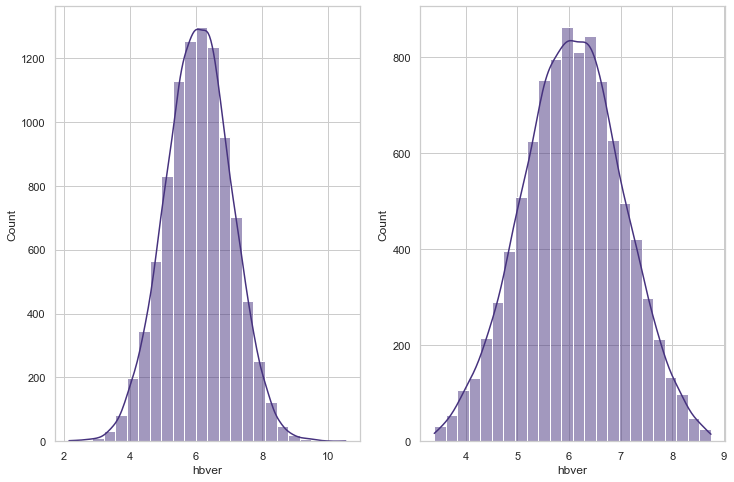

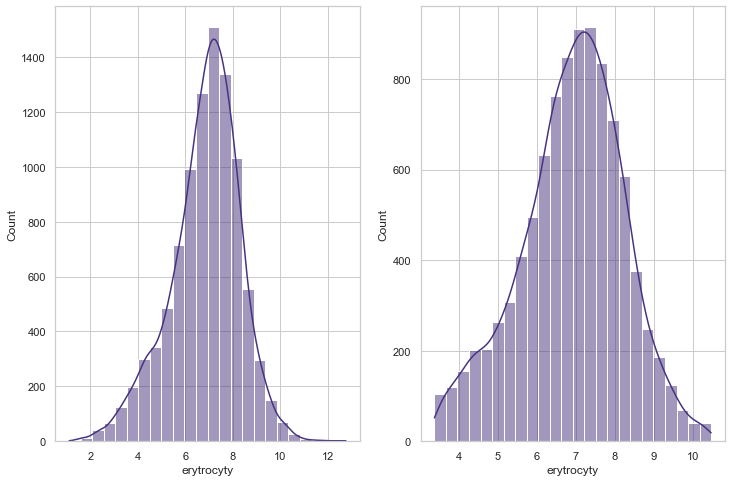

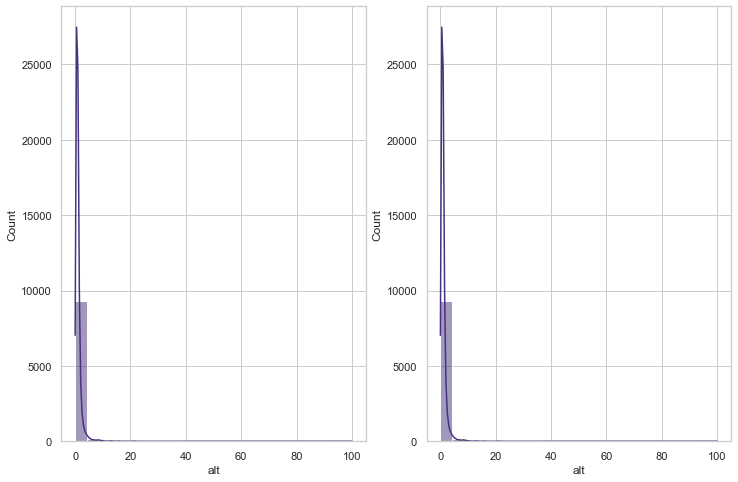

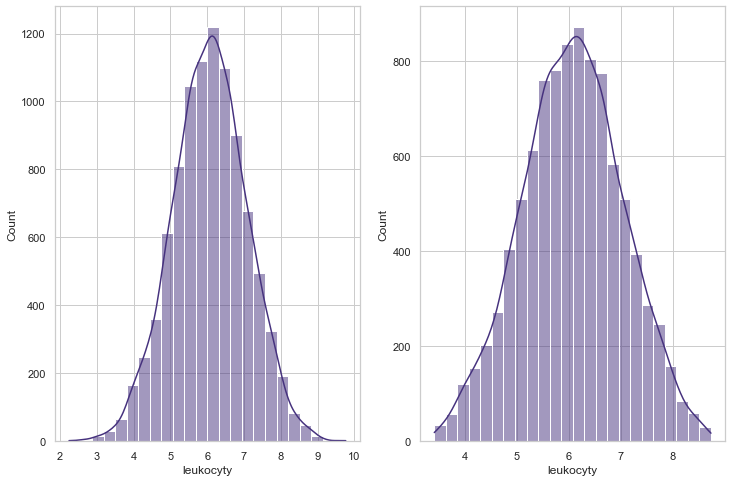

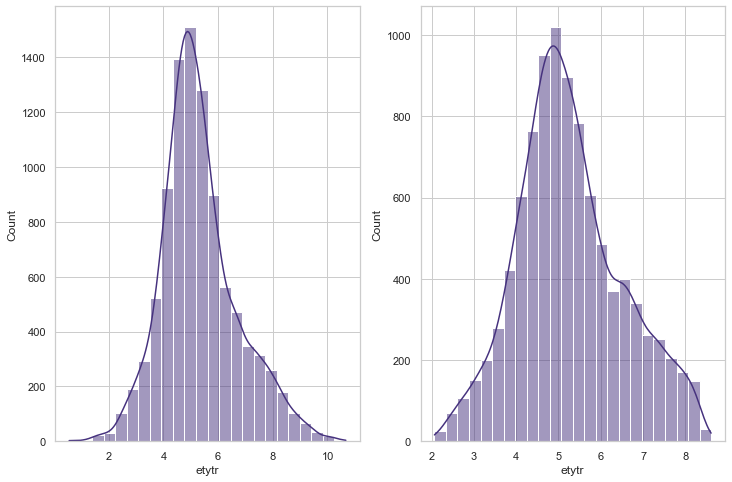

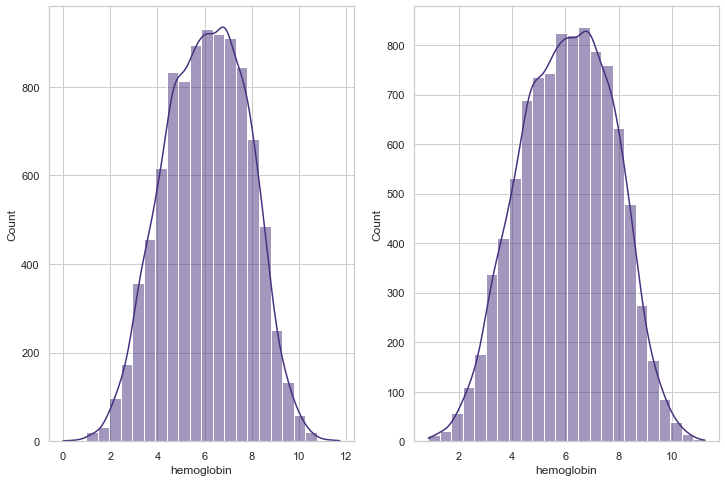

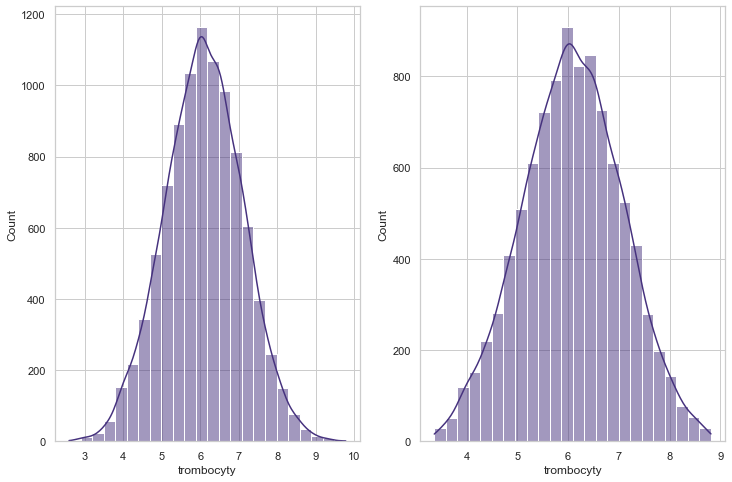

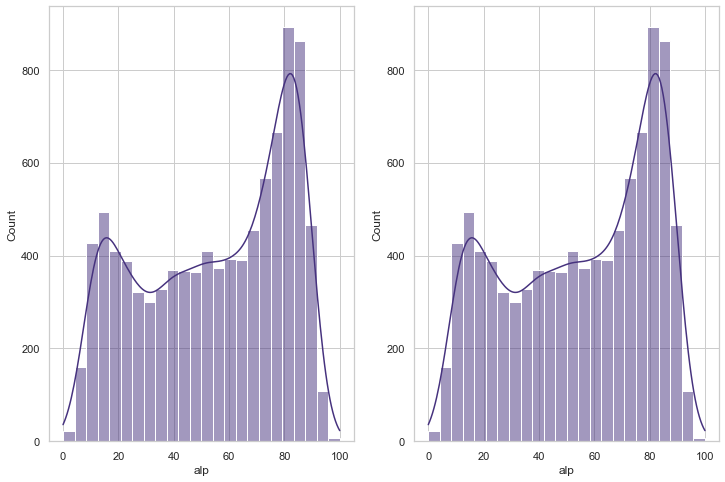

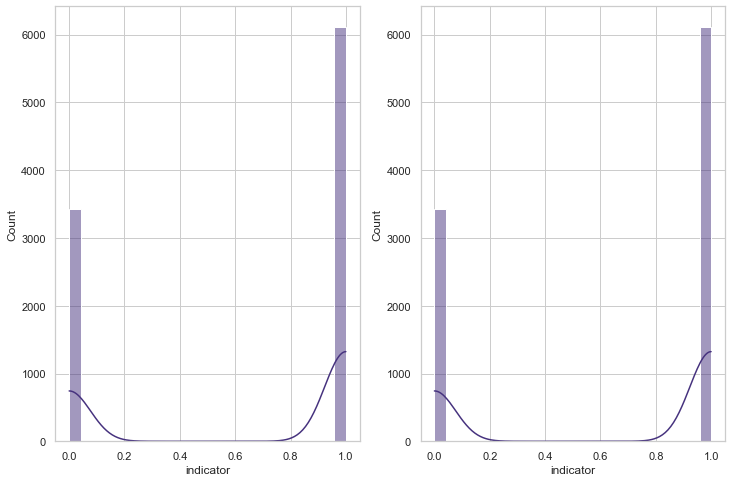

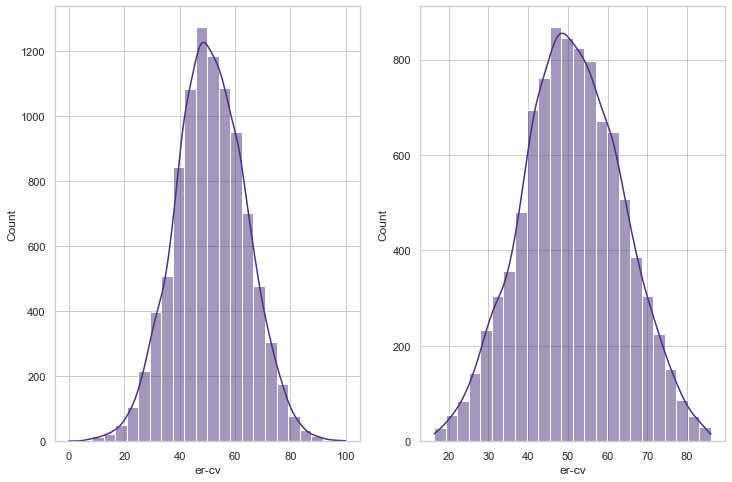

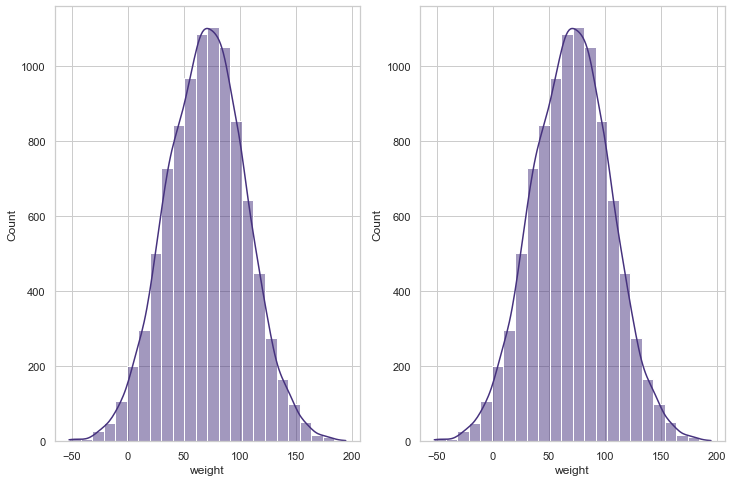

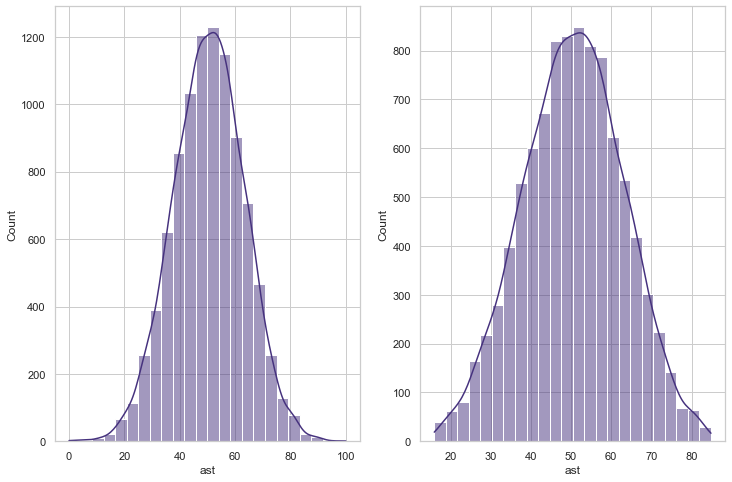

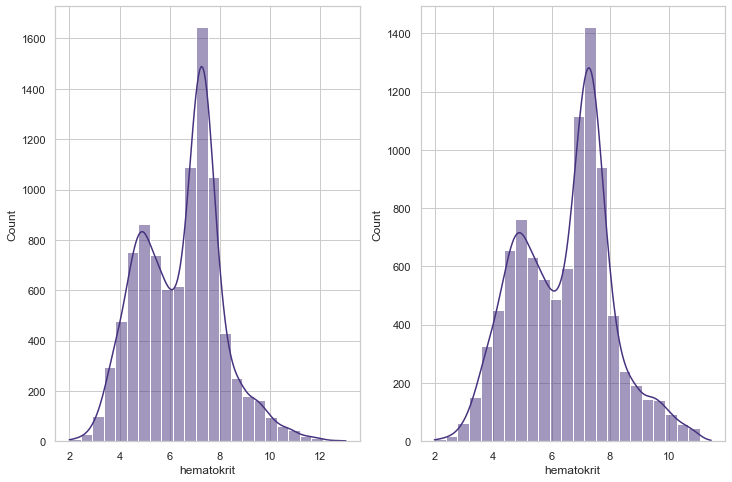

In [434]:
display_numerical_histplots(merged_data, testing_merged_data, float_columns)

### ZÁVER PRE VYCHÝLENÉ HODNOTY

Z analýzy dvoch rôznych riešení pre výchylené hodnoty sme zistili,
že odstraňovanie "outlierov" má za následok výrazné zredukovanie
počtu riadkov v datasete o viac než 20%. Tento prístup sa nám nepáči
nie len z toho dôvodu, že prichádzame o veľké množstvo dát, ale aj preto,
že vychýlené hodnoty sú do istej miery potrebné, keďže práve na takých
hodnotách sa môže náš machine-learning učiť najlepšie.

Preto sme sa rozhodli na našich dátach vykonať úpravu vychýlených hodnôt
nahradením adekvátnejšej hodnoty, ktorá nie je až tak vychýlená.

Z analýzy vyššie sme zistili, že tento prístup funguje na všetkých
atribútoch okrem:

* alt
* weight

Tie ošetríme individuálne.

In [435]:
testing_merged_data = merged_data.copy()
testing_merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Zmenili sme dátový typ indikátora na **int**, keďže tieto hodnoty nechceme meniť v ďaľších krokoch.

In [436]:
testing_merged_data["indicator"] = testing_merged_data["indicator"].astype(int)

testing_merged_data


,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.40520,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Vyberali sme iba hodnoty typu **float**, pretože hodnoty typu **int** značia rasu, krvnú skupinu, spoločenský stav,
pohlavie, fajčiara alebo indikator. Tieto hodnoty sú unikátne a preto ich nemožno posúvať.

In [437]:
target_columns = testing_merged_data.select_dtypes(include=[np.float]).describe().columns
target_columns = target_columns.drop("weight")
target_columns = target_columns.drop("alt")
target_columns

C:\Users\PC\AppData\Local\Temp/ipykernel_10356/331505997.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target_columns = testing_merged_data.select_dtypes(include=[np.float]).describe().columns


Index(['hbver', 'erytrocyty', 'leukocyty', 'etytr', 'hemoglobin', 'trombocyty',
       'alp', 'er-cv', 'ast', 'hematokrit'],
      dtype='object')

Nasleduje úprava regulárnych numerických atribútov.

In [438]:
for column in target_columns:
    lower, upper = iqr_calc(testing_merged_data, column, False)
    outliers = []
    for row in testing_merged_data[column]:
        if row < lower:
            outliers.append(row + lower)
        elif row > upper:
            outliers.append(row - lower)
        else:
            outliers.append(row)
    testing_merged_data[column] = outliers

V bunke nižšie je individuálna úprava váhy, ktorú sme upravili tak, že
sme k váham menším ako 5 pripočítali priemer.

In [439]:
for x in testing_merged_data.index:
    if testing_merged_data.loc[x, "weight"] < 5:
        testing_merged_data["weight"][x] = testing_merged_data["weight"][x] + testing_merged_data["weight"].mean()


A tu je úprava atribútu alt, v ktorom sme si ponechali vychýlené dáta,
no znormalizovali sme ich do užšieho intervalu.

In [440]:
lower, upper = iqr_calc(testing_merged_data, "alt", False)

for x in testing_merged_data.index:
    if testing_merged_data.loc[x, "alt"] > upper:
        testing_merged_data["alt"][x] = (testing_merged_data["alt"][x]/(upper*25)) + upper


Vykreslenie distribúcií pred a po vykonaní zmien.

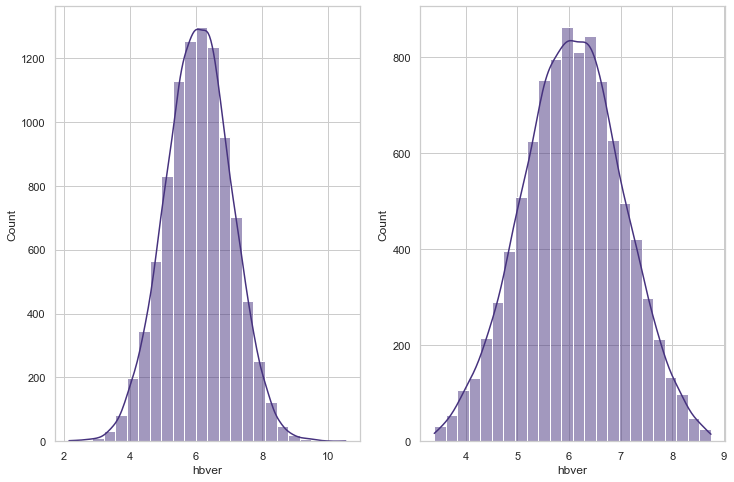

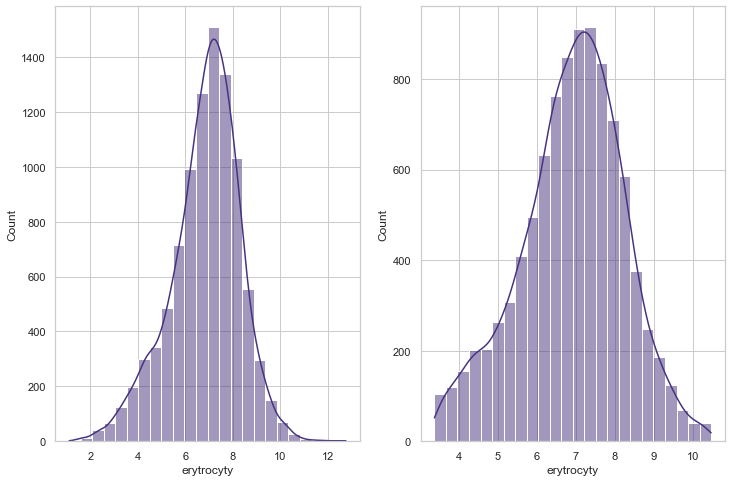

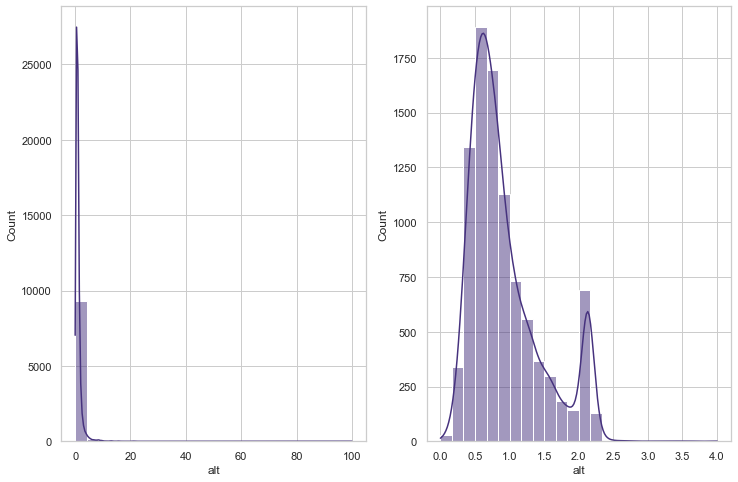

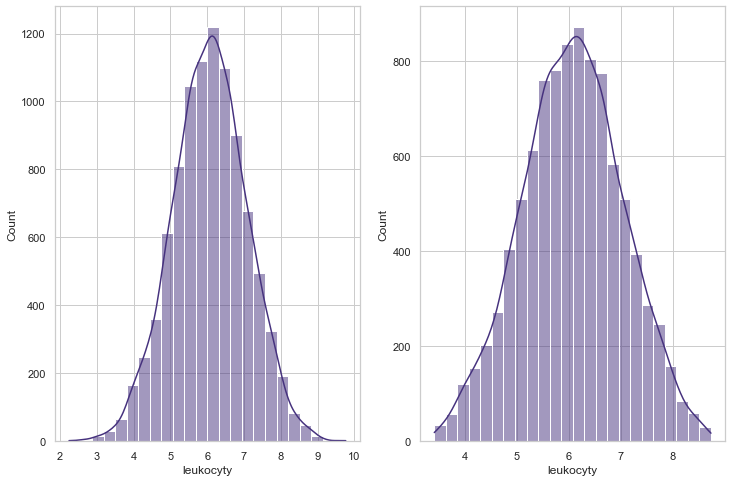

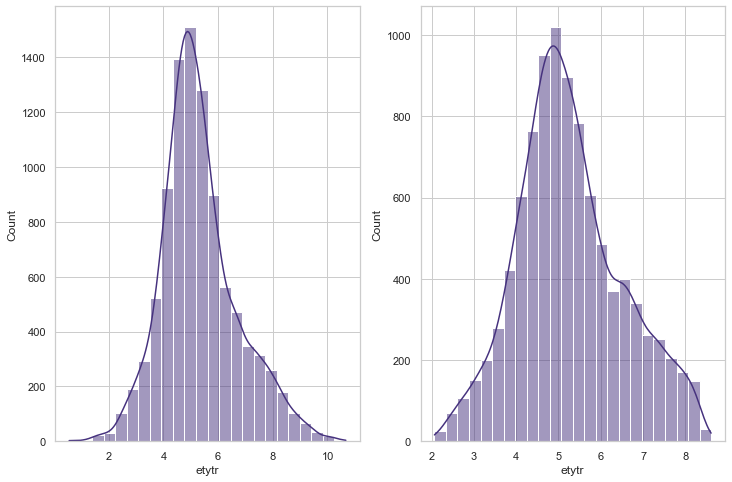

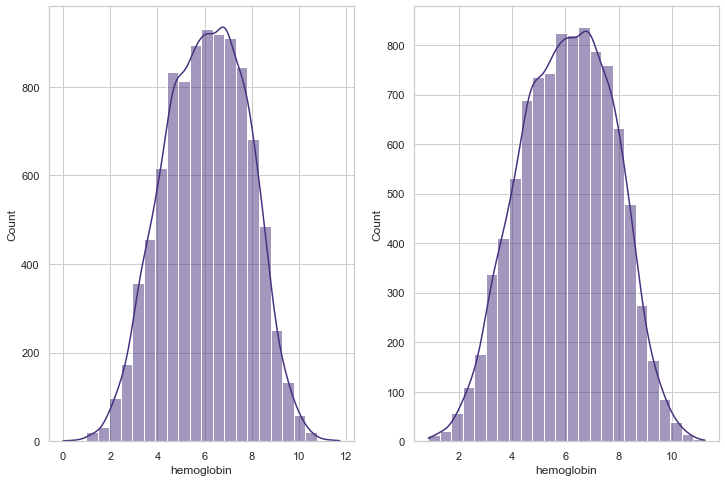

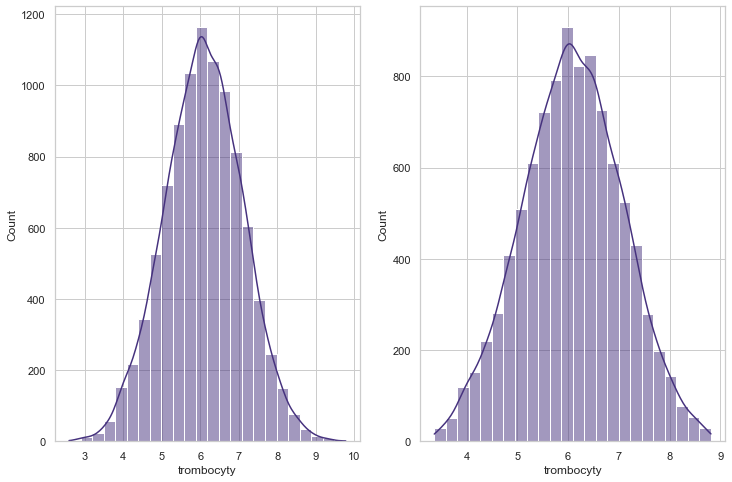

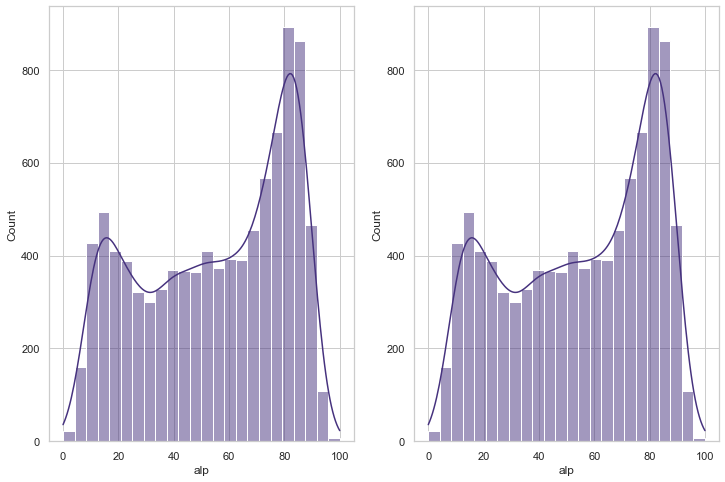

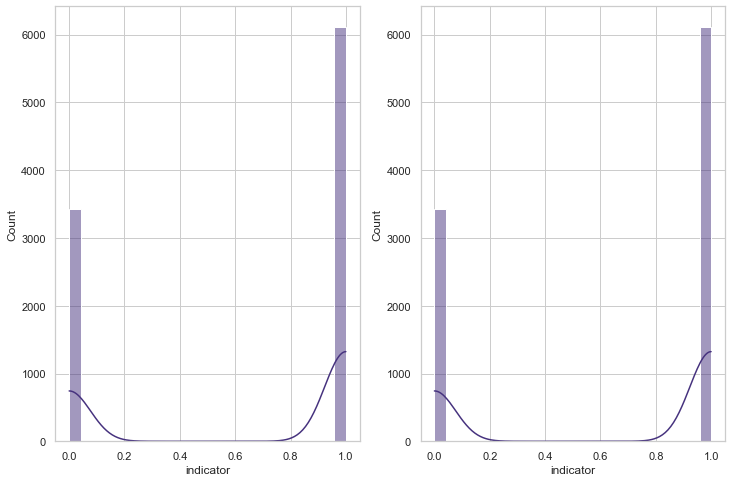

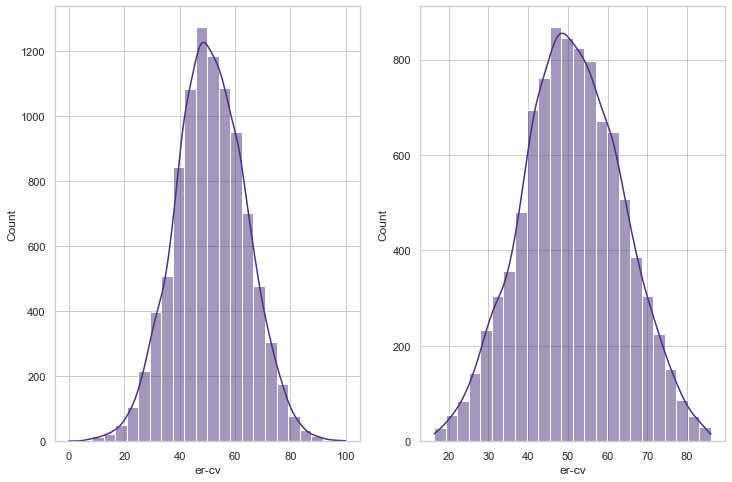

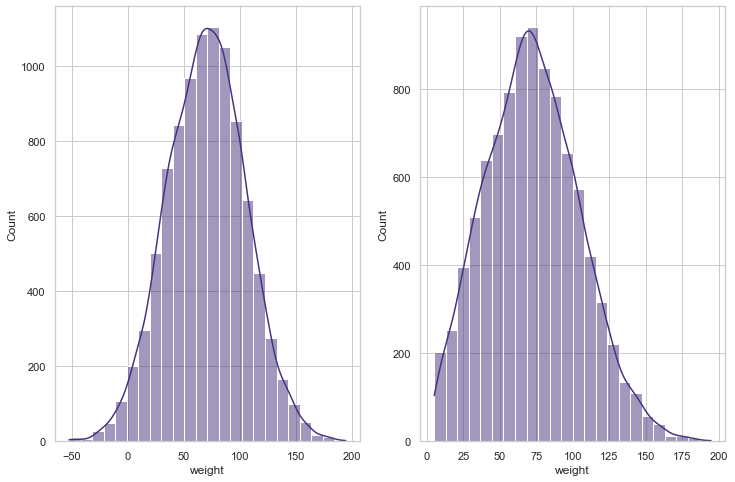

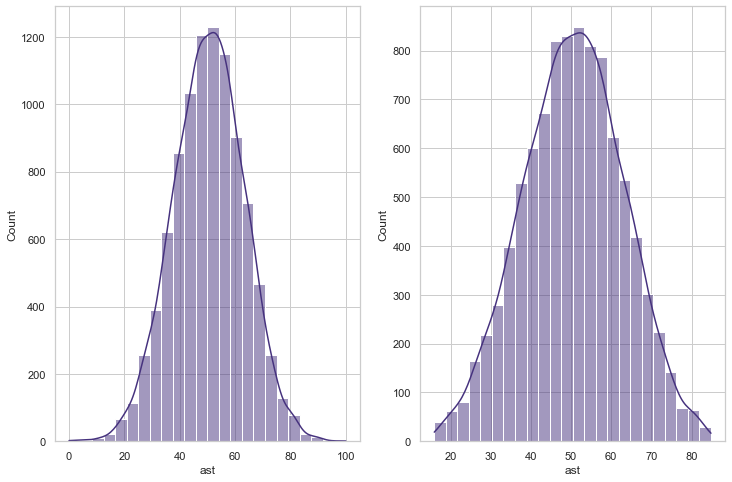

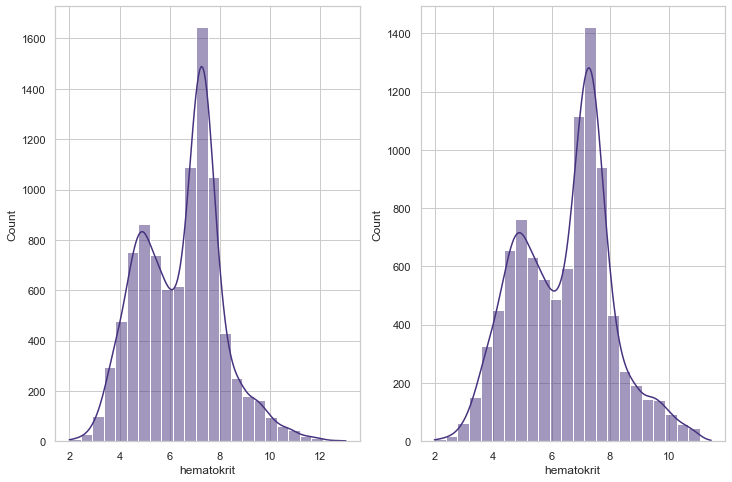

In [441]:
display_numerical_histplots(merged_data, testing_merged_data, float_columns)

Nahradenie pôvodného datasetu novým, s vykonanými úpravami.

In [442]:
merged_data = testing_merged_data.copy()

## b) Realizácia predspracovania dát


V prvom rade, sme si odstránili všetky nenumerické atribúty medzi ktoré patria:
* name
* ssn
* address
* residence
* location
* birthdate

In [443]:
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,ssn,name_x,trombocyty,...,ast,hematokrit,birthdate,address,race,current_location,blood_group,name_y,sex,residence
0,1,4.98718,8.89463,2.11712,5.75830,6.93712,4.54976,021-87-4523,Jeremy Tanner,6.23782,...,51.62366,3.34206,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,021-87-4523,Jeremy Tanner,7.42732,...,59.24840,6.85814,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,021-87-4523,Jeremy Tanner,5.42279,...,46.12997,6.78850,1923-05-10,"PSC 7581, Box 0898 APO AA 06225",0,"56.944534, 42.355764",4,Jeremy Tanner,1,"6041 Henry Inlet Harrishaven, KS 63783"
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,513-39-9691,Jocelyn Kelly,6.27100,...,61.59374,5.78180,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,513-39-9691,Jocelyn Kelly,7.03818,...,64.44051,8.14506,1923-12-08,"175 Anita Pass Lake Davidchester, NC 93833",0,"84.160623, 21.685531",6,Jocelyn Kelly,0,"04425 Wilson Crescent Apt. 364 Lisashire, WY ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,774-29-8698,Stacy Young,5.95845,...,56.75972,6.44557,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,774-29-8698,Stacy Young,5.86267,...,35.73155,5.78540,1990-10-21,"5329 Green Circle West Janet, CO 94192",4,"89.633417, 92.757661",4,Stacy Young,0,"3827 Sullivan Manor Suite 578 Joehaven, ID 19902"
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,461-85-3049,Jason Santos MD,6.82832,...,51.29995,7.69555,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,461-85-3049,Jason Santos MD,8.27491,...,27.24570,7.23617,1916-02-13,"4749 Ashley Mission New Natalie, ME 97315",4,"60.916302, -46.237649",6,Jason Santos MD,1,"782 Cross Glen Apt. 928 Melissaland, NE 05568"


Uloženie dát do nového .csv súboru pred úpravami v prípade, že by sme sa k nim chceli vrátiť.

In [444]:
merged_data.to_csv("dataset/merged.csv")

Odstránenie všetkých atribútov typu object, resp. stringov.

In [445]:
merged_data.drop(merged_data.select_dtypes(include = {'object', 'datetime64'}), axis = 1, inplace = True)

merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,trombocyty,alp,relationship,indicator,er-cv,weight,ast,hematokrit,race,blood_group,sex
0,1,4.98718,8.89463,2.11712,5.75830,6.93712,4.54976,6.23782,45.93625,4,0,55.43592,67.600407,51.62366,3.34206,0,4,1
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,7.42732,50.72980,1,1,62.99586,146.161350,59.24840,6.85814,0,4,1
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,5.42279,54.52797,1,1,61.66052,90.390840,46.12997,6.78850,0,4,1
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,6.27100,20.30249,4,0,45.34617,81.565330,61.59374,5.78180,0,6,0
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,7.03818,84.46671,4,1,45.02880,93.784280,64.44051,8.14506,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,5.95845,71.09634,4,1,62.05093,96.062210,56.75972,6.44557,4,4,0
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,5.86267,33.94788,3,0,61.71716,43.582210,35.73155,5.78540,4,4,0
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,6.82832,54.70713,5,1,82.43138,18.298130,51.29995,7.69555,4,6,1
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,8.27491,81.65971,2,1,62.57684,113.125630,27.24570,7.23617,4,6,1


Overenie ponechania výhradne numerických atribútov.

In [446]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9542 entries, 0 to 9541
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   smoker        9542 non-null   int32  
 1   hbver         9542 non-null   float64
 2   erytrocyty    9542 non-null   float64
 3   alt           9542 non-null   float64
 4   leukocyty     9542 non-null   float64
 5   etytr         9542 non-null   float64
 6   hemoglobin    9542 non-null   float64
 7   trombocyty    9542 non-null   float64
 8   alp           9542 non-null   float64
 9   relationship  9542 non-null   int64  
 10  indicator     9542 non-null   int32  
 11  er-cv         9542 non-null   float64
 12  weight        9542 non-null   float64
 13  ast           9542 non-null   float64
 14  hematokrit    9542 non-null   float64
 15  race          9542 non-null   int64  
 16  blood_group   9542 non-null   int64  
 17  sex           9542 non-null   int32  
dtypes: float64(12), int32(3), in

In [447]:
from sklearn.model_selection import train_test_split

def split_data(dataset, size, state):
    X_nonindicator = dataset.loc[:, dataset.columns != "indicator"]
    y_indicator = dataset[["indicator"]]
    X_training, X_testing, y_training, y_testing = train_test_split(X_nonindicator, y_indicator,
                                                        test_size=size, random_state=state)
    return X_training, X_testing, y_training, y_testing

In [448]:
merged_data

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,trombocyty,alp,relationship,indicator,er-cv,weight,ast,hematokrit,race,blood_group,sex
0,1,4.98718,8.89463,2.11712,5.75830,6.93712,4.54976,6.23782,45.93625,4,0,55.43592,67.600407,51.62366,3.34206,0,4,1
1,0,5.00648,7.27841,0.82563,5.54481,5.03221,7.70354,7.42732,50.72980,1,1,62.99586,146.161350,59.24840,6.85814,0,4,1
2,1,6.71966,7.01351,1.00377,5.66778,5.12799,7.73316,5.42279,54.52797,1,1,61.66052,90.390840,46.12997,6.78850,0,4,1
3,1,6.67732,4.21847,0.66072,6.29064,5.19990,4.10863,6.27100,20.30249,4,0,45.34617,81.565330,61.59374,5.78180,0,6,0
4,1,6.06875,5.68453,0.58818,3.90764,5.87943,6.89656,7.03818,84.46671,4,1,45.02880,93.784280,64.44051,8.14506,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9537,1,5.56044,7.88598,1.25698,6.44806,4.91910,5.42717,5.95845,71.09634,4,1,62.05093,96.062210,56.75972,6.44557,4,4,0
9538,0,6.02362,4.17512,0.51225,5.81361,5.63849,4.22984,5.86267,33.94788,3,0,61.71716,43.582210,35.73155,5.78540,4,4,0
9539,1,5.63262,5.74856,0.39597,7.16376,5.98503,7.57294,6.82832,54.70713,5,1,82.43138,18.298130,51.29995,7.69555,4,6,1
9540,0,6.74328,7.27587,0.98270,4.87883,4.79271,6.66698,8.27491,81.65971,2,1,62.57684,113.125630,27.24570,7.23617,4,6,1


In [449]:
X_train, X_test, y_train, y_test = split_data(merged_data, 0.25, 25)

In [450]:
X_train

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,trombocyty,alp,relationship,er-cv,weight,ast,hematokrit,race,blood_group,sex
7433,1,7.11577,6.89604,0.87475,4.27852,5.18967,6.74443,6.05354,83.83442,0,52.97515,67.80356,30.53281,7.36825,4,6,0
5970,0,6.21022,4.75367,0.40265,4.91083,5.65163,4.93825,6.16399,55.78735,4,41.74361,51.53481,45.98273,4.67414,4,4,1
2732,0,6.98939,5.48411,0.63729,6.01959,4.59255,4.85923,5.97029,53.63644,4,77.03702,67.65246,25.34113,7.58605,4,2,1
4647,1,4.14123,4.54228,0.19204,6.68938,6.85113,7.71531,7.64038,55.17149,4,49.96126,33.91436,34.55417,8.29635,4,4,1
2235,0,5.38337,7.49654,1.09066,7.26850,5.34412,3.46287,6.67480,16.61751,1,47.17137,84.59153,52.05354,8.65907,2,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,0,5.03378,7.07644,0.74868,6.61567,4.53641,4.22759,5.77337,33.47031,5,64.02449,72.64568,62.99343,7.07865,1,3,0
8447,1,4.19229,5.74996,0.50020,5.10005,6.42235,9.62790,7.39094,12.09416,2,54.06941,67.99203,43.19515,6.49353,4,6,1
2934,0,6.15958,6.68865,0.58624,5.11874,5.32299,6.83223,7.13814,74.96693,0,51.49852,93.96373,46.74690,7.50798,3,7,1
6618,0,6.78041,7.14476,0.88021,6.11030,2.92355,5.74362,5.33375,89.12130,2,60.92369,50.71782,56.75800,3.34776,4,2,1


In [451]:
X_test

,smoker,hbver,erytrocyty,alt,leukocyty,etytr,hemoglobin,trombocyty,alp,relationship,er-cv,weight,ast,hematokrit,race,blood_group,sex
6409,0,6.03423,6.404260,0.599900,4.65384,4.87438,4.82234,5.93582,50.93144,2,64.59131,48.67240,28.83709,7.20419,1,5,0
3588,1,4.71355,6.695842,0.569920,7.94259,8.01067,9.75886,5.65609,12.65894,2,41.73128,91.44908,51.66456,7.64759,0,3,1
1548,1,6.03920,8.077850,1.494050,7.45209,6.00264,4.12625,6.63690,25.99240,2,38.20987,83.02124,25.82746,8.79688,1,6,1
4348,1,6.64693,8.922550,2.118991,6.32866,6.28105,5.00473,6.00103,59.67563,0,45.83513,90.29187,55.22106,3.16730,4,5,1
2006,0,5.72025,5.643650,0.573110,5.88083,6.50695,9.59458,4.81289,8.53021,4,42.00761,70.95643,33.72688,7.65402,4,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,0,5.02338,8.024750,1.428920,6.63009,5.29343,4.33189,6.75456,34.31302,3,71.01298,107.60256,30.98959,8.07642,4,7,0
7249,0,5.76382,8.661470,1.853750,5.69670,3.39434,5.71703,6.25907,85.99623,1,39.74756,124.47906,39.74532,3.32588,1,6,0
684,0,5.75719,7.060460,0.675770,5.75068,4.29645,4.07855,6.08234,25.10811,2,56.11850,83.30527,63.28277,5.06710,4,3,1
747,0,6.14067,5.412250,0.614730,4.40173,3.86452,5.88575,6.62729,82.70474,3,46.43984,141.21917,53.38619,4.26845,1,2,1


In [452]:
y_train

,indicator
7433,1
5970,0
2732,1
4647,1
2235,1
...,...
1175,1
8447,1
2934,1
6618,0


In [453]:
y_test

,indicator
6409,1
3588,1
1548,1
4348,0
2006,1
...,...
7414,1
7249,0
684,1
747,0


Na transformáciu numerických atribútov, aby boli vhodné pre strojové učenie,
sme si zvolili 2 techniky, a to - transformovanie a škálovanie.

Na transformovanie datasetu sme si zvolili PowerTransformer z sklearn a konkrétne
metódu transformácie yeo-johnson. Tá upraví hodnoty datasetu tak, aby mali viac
Gaussovu distribúciu, čo priamo napomáha úspešnosti predikovania pri použití regresie.

Na škálovanie sme použili MinMaxScaler() z sklearn. Scaling datasetu vykoná to,
že sa hodnoty datasetu znormalizujú do intervalu <0;1>, čo má za následok
korektnejšie predikovanie modelu, keďže regresné modely si vytvárajú istý bias
k atribútom, ktorých hodnoty sú z väčších intervalov, čo je nežiadúci dôsledok.

In [454]:
def transform_and_scale_dataset(dataset):
    pipeline = Pipeline([('power', PowerTransformer(method='yeo-johnson', standardize=False)),
                         ('scaler', MinMaxScaler())])
    print(pipeline)
    pipeline.fit(dataset)
    transformed = pipeline.transform(dataset)
    #transformed.columns = dataset.columns.copy()

    return transformed

Tieto predspracovania realizujeme iba na trénovacej zadaní, ako je povedané v zadaní.
Nižšie v bunke je vykonané práve to.

In [455]:
transformed_X_train = transform_and_scale_dataset(X_train)
transformed_X_train

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


array([[1.        , 0.69715682, 0.43097367, ..., 1.        , 0.88226708,
        0.        ],
       [0.        , 0.52885586, 0.15206716, ..., 1.        , 0.63102667,
        1.        ],
       [0.        , 0.67369967, 0.24143241, ..., 1.        , 0.34848989,
        1.        ],
       ...,
       [0.        , 0.51942824, 0.40179955, ..., 0.73069854, 1.        ,
        1.        ],
       [0.        , 0.63488965, 0.46654877, ..., 1.        , 0.34848989,
        1.        ],
       [1.        , 0.66884666, 0.32468422, ..., 0.2263037 , 0.88226708,
        1.        ]])

Tu je grafické vykreslenie po transformácii a škálovaní.
Grafy vľavo sú pôvodné dáta a grafy vpravo predstavujú distribúcie
atribútov po vykonaní transformácie a škálovania.

C:\Users\PC\AppData\Local\Temp/ipykernel_10356/767919490.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  float_columns = X_train.select_dtypes(include=[np.float]).describe().columns


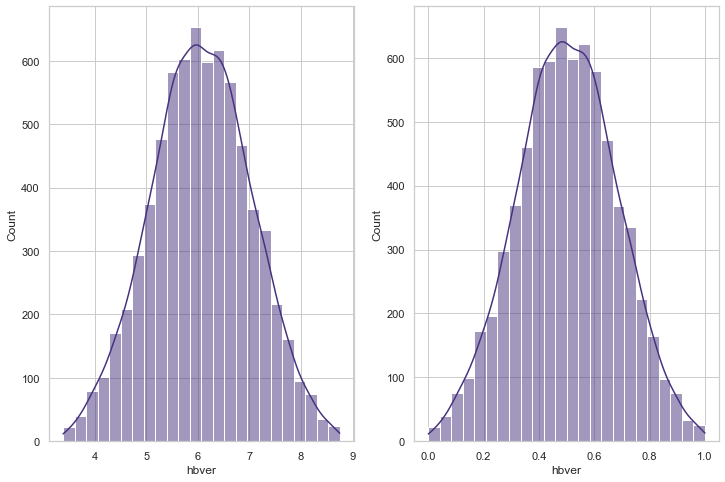

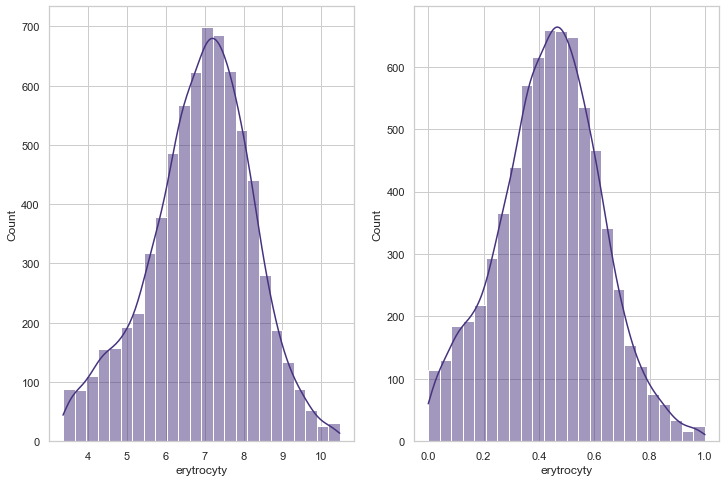

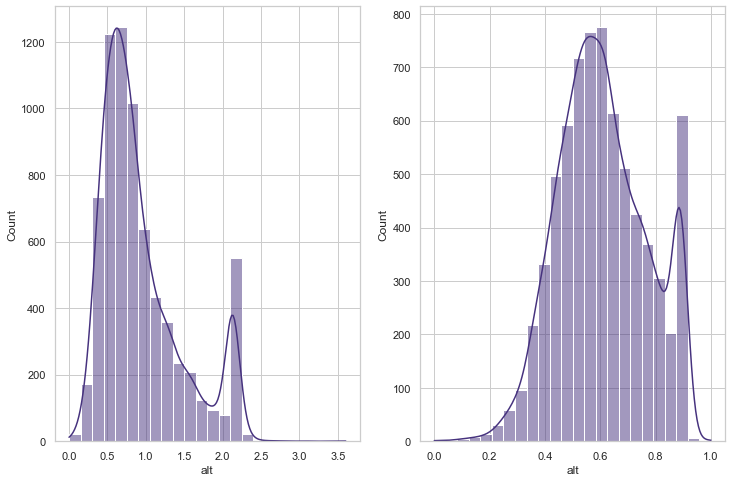

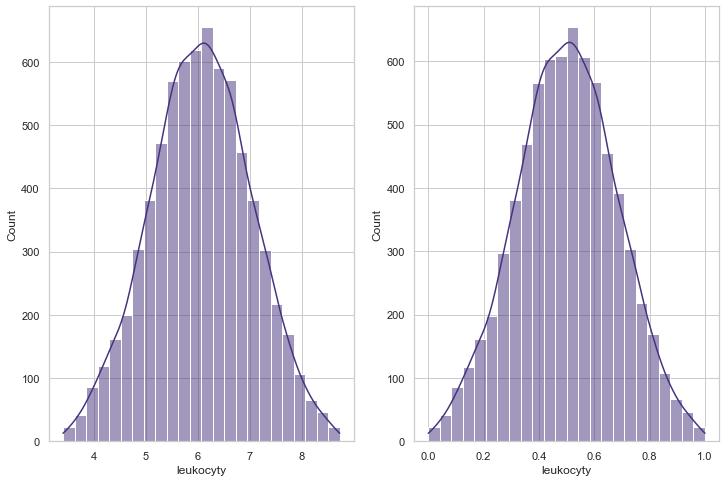

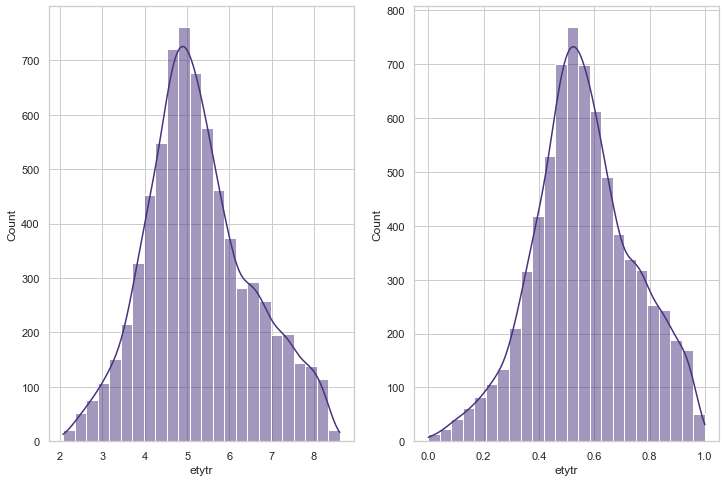

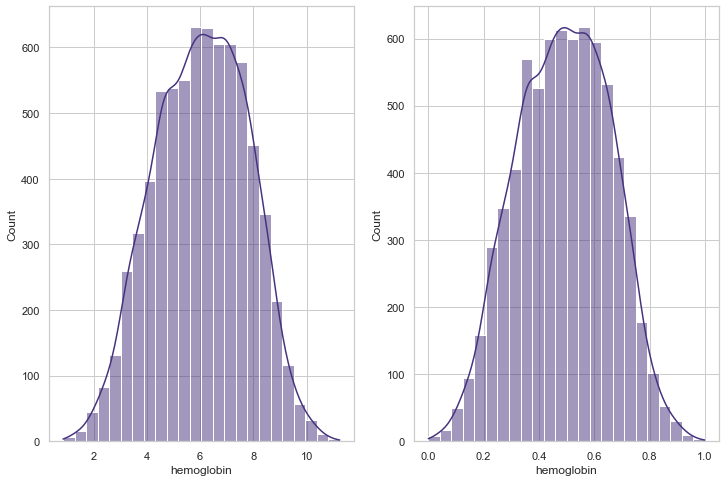

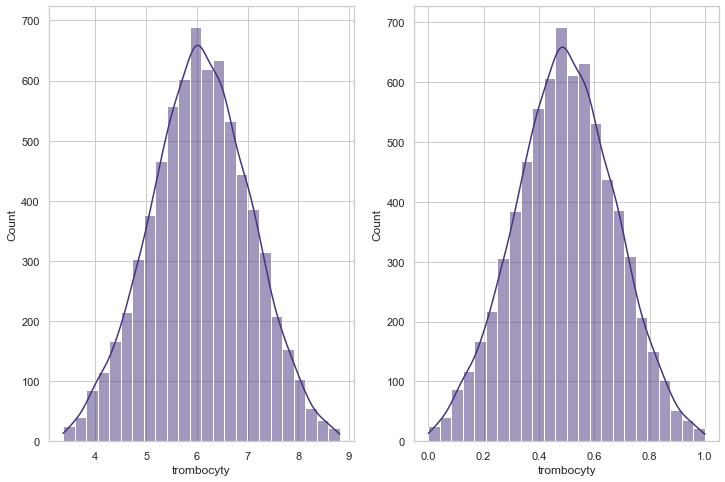

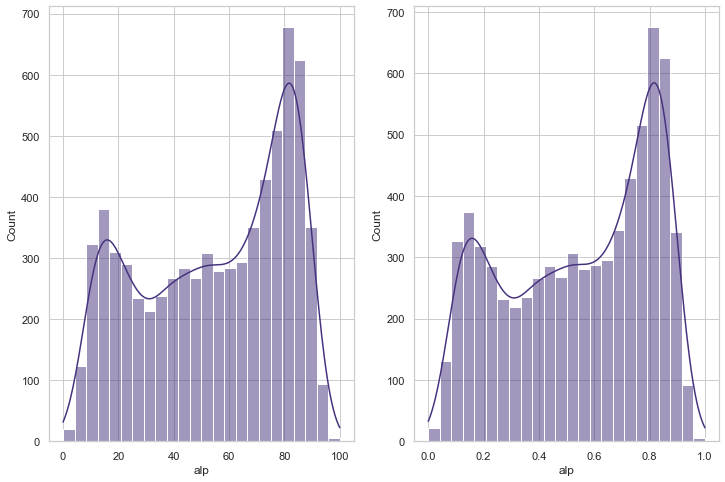

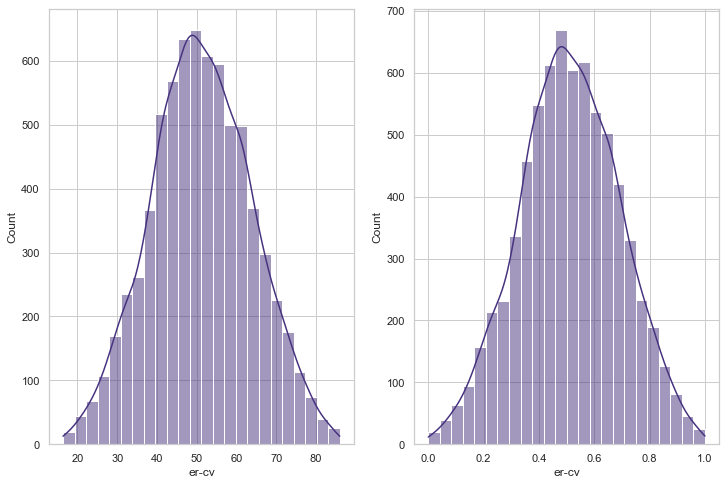

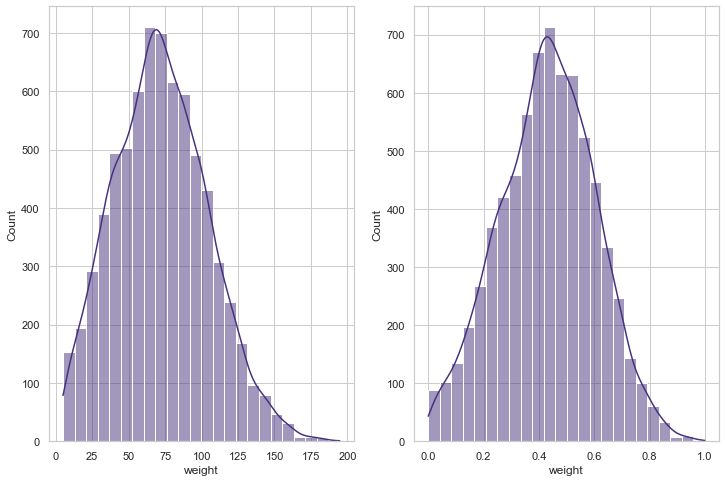

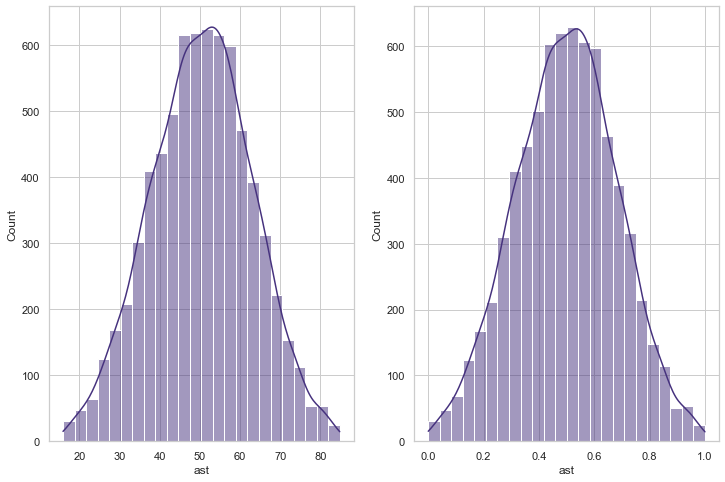

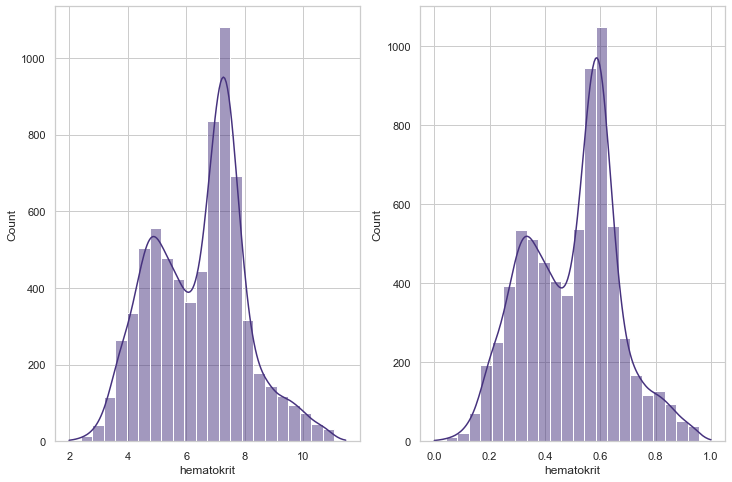

In [456]:
transformed_X_train_dataset = pd.DataFrame(transformed_X_train, columns=X_train.columns)
float_columns = X_train.select_dtypes(include=[np.float]).describe().columns

display_numerical_histplots(X_train, transformed_X_train_dataset, float_columns)

## c) Výber atribútov pre strojové učenie

V tejto časti sa povenujeme tzv. feature selection, teda vyberaniu
atribútov, ktoré sú dôležité pre náš dataset a majú dopad
na predikovanú premennú.

Pre vyberanie atribútov sme si zvolili metódu SelectFromModel
Pre túto metódu sme sa rozhodli:
* vracia číselné ohodnotenia
* vie správne nastaviť ohodnotenie, na základe ktorého sa vyberajú atribúty
* vyberá atribúty na základe dôležitosti (korelácie), z predošle nastaveného ohodnotenia


In [457]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

def feature_selection_model(data_X, data_Y):
    selector = SelectFromModel(estimator=LogisticRegression(), threshold=0, max_features=5).fit(data_X, data_Y)
    print(selector.estimator_.coef_)
    print(selector.threshold_)
    print(selector.get_support())

    X_new = selector.transform(X_train)
    print(X_new.shape)

    return X_new

Vykonanie selekcie dôležitých atribútov na trénovacom datasete.

In [458]:
feature_selection_model(transformed_X_train, y_train)

[[ 0.03026357  0.05276936  3.73602695  1.05557747  0.07930344 -4.97316691
  -0.41556407  0.13826405 -0.26865087 -0.22995889 -0.03415733 -0.21223787
   0.01761672 15.14007187  0.07092587 -0.21436645 -0.13385649]]
0.0
[False False  True  True False  True  True False False False False False
 False  True False False False]
(7156, 5)


C:\Users\PC\Desktop\IAU_project\venv\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\PC\Desktop\IAU_project\venv\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


array([[6.89604, 0.87475, 5.18967, 6.74443, 7.36825],
       [4.75367, 0.40265, 5.65163, 4.93825, 4.67414],
       [5.48411, 0.63729, 4.59255, 4.85923, 7.58605],
       ...,
       [6.68865, 0.58624, 5.32299, 6.83223, 7.50798],
       [7.14476, 0.88021, 2.92355, 5.74362, 3.34776],
       [6.12413, 0.4398 , 5.79679, 8.17566, 7.26986]])

## d) Replikovateľnosť predspracovania

Vo funkcii **transform_and_scale_dataset** v bode **b)** sme uvažovali dopredu
a už tam sme využili Pipeline, kde sme skombinovali PowerTransformer a MinMaxScaler.
Na základe tejto skutočnosti, nepotrebujeme v tomto kroku znova vytvárať Pipeline

In [459]:
transformed_X_test = transform_and_scale_dataset(X_test)

Pipeline(steps=[('power', PowerTransformer(standardize=False)),
                ('scaler', MinMaxScaler())])


Vyexportovanie všetkých sád, ktoré máme k dispozícii

In [460]:
y_train.to_csv("dataset/y_train.csv")

In [461]:
y_test.to_csv("dataset/y_test.csv")

In [462]:
transformed_X_train_DataFrame = pd.DataFrame(transformed_X_train)
transformed_X_train_DataFrame.to_csv("dataset/transformed_X_train.csv")

In [463]:
transformed_X_test_DataFrame = pd.DataFrame(transformed_X_test)
transformed_X_test_DataFrame.to_csv("dataset/transformed_X_test.csv")
